### Overview

This notebook is a 2 part hands-on demonstration of working with Amazon review data for text analytics. The first part uses LDA and Kmeans algorithms to automatically group together reviews based on topics discussed within the text. The second part covers predicting review scores using SVM and Logistic Regression based on contents of the review. The end shows how to predict the rating of a new review based on the models.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

### Import review data

Amazon reviews can span from 1 star to 5 stars. The difference between a 1-2 or a 4-5 might be very noisy when we build predictions. Instead, we bucket reviews by:

- Low: 1-2 Stars
- Neutral: 3 Stars
- High: 4-5 Stars

Reviews are filtered to those with at least 45 words to avoid short, uninformative reviews like "This is great!". After limiting, we take a stratified sample of 6000 reviews from each bucket to get reasonable performance from sklearn in Python. The stratification helps us overcome the bias in that 80% of the reviews have 4-5 star ratings.

In [41]:
file_name = "rawdata.pkl"
cat = [0, 1]

data = pd.read_pickle(file_name)
data = data.rename(index=str, columns={"overall": "bucket"})
pd.set_option('display.max_colwidth', -1)
data.sample(3)

,bucket,reviewText
520865,1,Fits and works perfectly with &#34;My K-Cup&#34; adapter. Recommend Dark Roast coffee for best flavor. Very economical to use. Keeps the coffee grinds out of the coffee.
143595,0,"My fault I ordered too small, but what I really didn't like was that the wire used was too thick and therefore too stiff. Oh well :) I'll keep shopping."
180684,1,"For the last 5 years I've used a Lasko oscillating fan to supplement the A/C in my west-facing den. The summers can be brutal here in SC. To be honest I've never heard of an air circulator until I ran across this item on amazon. My den is not as well air conditioned as the rest of the house due to poor ducting and afternoon sun. Add the heat that the big screen TV gives off and things can get pretty uncomfortable. So I placed this fan in an adjoining room that stays cool and pointed towards the den. BIG improvement!I keep fan set on the medium setting and the den now has a nice gentle breeze wherever you're sitting. I don't know what others are complaining about noise. It's completely unnoticeable when the tv is on. It's not at all bad when its off.This is a big improvement for me. Bring on the heat and humidity. I'm ready!UPDATE 06/24/13: Hello summer! It's been very late arriving this year but the good old heat and humidity that we deal with in the south has arrived full force. It is currently 92 degrees with 80% humidity right now at 5pm. The sun is blasting my den windows as we speak but I'm totally comfortable. My vornado is quietly working on medium speed in the next room. Wherever I sit in the room I feel a cool, light breeze. It's not at all like a direct fan but a gentle, light breeze. This fan has been running 24/7 for about six weeks now and will probably not be turned off until October. I'm very pleased with my purchase."


In [ ]:
cat = ['low','neutral','high']
def cat_y(y):
    if y<=2.0:
        return cat[0]
    elif y>=4.0:
        return cat[2]
    else:
        return cat[1]

def get_reviews(path, n_samples):
    dt = {}
    i=0
    with open(path) as f:
        for d in f.readlines():
            dt[i] = eval(d)
            i += 1
    df = pd.DataFrame.from_dict(dt, orient='index')[['reviewText','overall']]
    df = df[df['reviewText'].apply(lambda x: len(x.split())>=45)]
    df['bucket'] = df['overall'].apply(cat_y)
    
    df = df.groupby('bucket').apply(lambda x: x.sample(n=n_samples))
    return df

data = get_reviews('data/reviews_Home_and_Kitchen_5.json', 6000)
pd.set_option('display.max_colwidth', -1)
data.sample(3)

### Calculate Term Frequencies

We calculate both the actual term frequency as well as the tfidf weighted term frequency. For both algorithms, we limit to words occuring in at most 90% of documents and in at least 10 documents. While the term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" words that occur in many reviews.

We perform two tokenizing operations. First, we tokenize only letters, ignoring special symbols & numbers. We use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

In [8]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(data['reviewText'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(data['reviewText'], use_idf=True, max_df=0.90, min_df=10)

### Compute topics using Kmeans and LDA

We are using two approaches to extract topics from our document set.

Approach 1 (Kmeans): Using our TFIDF matrix, we cluster documents into N clusters based on their TFIDF similarity. Within each cluster, we count the top occuring terms.

Approach 2 (LDA): Using our TF matrix, we attempt to extact N topics from our collection of documents.

It's a subtle but important difference. Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. I pulled 10 topics out of my head as a nice starting number. Further testing would have to be done to see if it was the best choice.

In [9]:
n_topics = 10

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_components=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

### Show cluster top 15 words per topic

Using the approach outlined in the sklearn documentation, we first extract the top 15 stemmed words per topic in our LDA model. As a second step, we do something similar for our kmeans clustered documents. Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [10]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model

Topic #0:
use, make, great, easi, love, work, clean, ice, bowl, food, bread, bake, just, perfect, like
Topic #1:
lid, plastic, open, use, bag, handl, fit, like, size, hold, contain, small, veri, bottl, design
Topic #2:
veri, set, like, good, knife, sheet, bed, qualiti, nice, look, mattress, size, price, cut, toaster
Topic #3:
look, veri, great, nice, piec, color, hold, stainless, like, sturdi, togeth, easi, good, slice, use
Topic #4:
pan, heat, cook, use, set, iron, pot, stick, hot, time, temperatur, non, water, egg, minut
Topic #5:
product, amazon, return, review, order, purchas, item, box, replac, ship, receiv, price, qualiti, custom, arriv
Topic #6:
use, just, work, time, like, don't, year, tri, i'm, bought, thing, buy, becaus, month, review
Topic #7:
coffe, cup, water, machin, use, make, filter, maker, tea, hot, grind, drink, brew, like, tast
Topic #8:
vacuum, clean, use, floor, unit, fan, air, power, veri, carpet, room, work, filter, do

In [11]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
toaster, toast, oven, bread, bagel, set, use, slice, burn, work, like, veri, look, time, year
Cluster #1:
use, work, time, just, clean, make, great, like, easi, water, veri, cook, year, product, onli
Cluster #2:
veri, look, great, like, product, nice, good, love, use, qualiti, just, size, fit, item, price
Cluster #3:
ice, blender, cream, cube, use, make, tray, smoothi, blend, drink, frozen, blade, work, like, freezer
Cluster #4:
pan, stick, use, cook, non, bake, fri, clean, cake, egg, veri, heat, great, handl, like
Cluster #5:
pillow, sheet, mattress, bed, sleep, comfort, soft, foam, veri, like, feel, cover, fit, night, memori
Cluster #6:
knife, knive, cut, sharp, sharpen, board, blade, use, slice, veri, edg, set, good, like, handl
Cluster #7:
filter, fan, air, water, unit, work, room, use, pitcher, veri, nois, quiet, just, replac, like
Cluster #8:
coffe, cup, maker, brew, make, water, filter, use, ground, pot, grind, machin

### Prepare data for plotting

Our TF/TFIDF matricies are thousands of attributes wide which makes it a challenge to graphically represent documents as we are limited to 3 dimensions. We could perform a heirarchical clustering, but the number of documents makes this approach very slow. Instead, we perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

We then use t-SNE to attempt to visually cluster and represent our data as best as possible in 2 dimensions. More information about t-SNE can be found at Laurens van der Maaten's site. In the end we will have a 2 dimensional matrix for our XY plot. Be sure to read the caveats of t-SNE plots as well.

Our Kmeans output already has cluster labels in it (eg. one cluster label per document). However LDA allows for a single document to cover multiple topics. One approach could be to perform a clustering on top of the LDA output. But for this example, I chose the dominant topic for each document as its label in the LDA model.

In [12]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

### Plot Data

Here we use our LDA and Kmeans labels with our reduced dimensions to plot our documents. We create a rainbow color scheme which allows for a variable number of topics/clusters. You could choose any other color map which suits your needs. I chose to plot this in 2D, however you could create 3 TSNE dimensions in the step above and create a 3D scatterplot as well.

The plot tends to overlap quite a bit. If you sample through some of the reviews you'll see many tend to use similar wording.

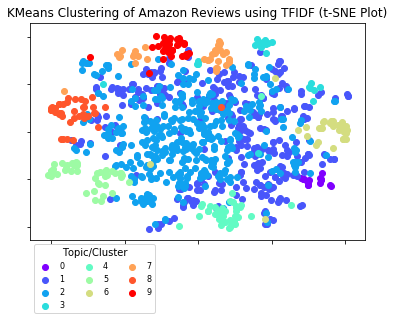

In [13]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

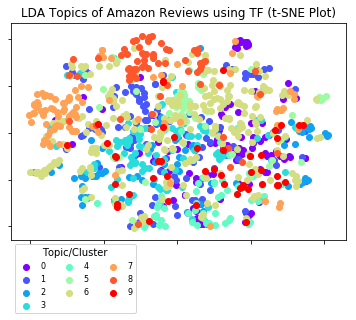

In [14]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

### Prepare data for rating prediction

The previous steps allowed us to understand how the data is structured, but it doesn't let us understand what drives positive or negative reviews. In the next steps, we look at the words within reviews to build a predictive scoring model.

When training these types of models, overfitting can occur where we become very good at predicting our sample data, but fail to predict on new data. To avoid this, we split the data 70%/30% where we reserve the 30% for gauging our final accuracy.

We will build 3 models. One that predicts low, one that predicts high, and one that predicts neutral. For each review, we run it against all three models. The model that scores the highest will tell us which kind of review it likely is.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, data['bucket'], test_size=0.3)

### Calculate model accuracies

We try 3 different approaches to building the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. We also try a final approach that does a combined "vote" of all three models. This means we are actually building (4 approaches) x (3 ratings) = 12 total models. Since we have limited data, we will use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

The accuracy % are printed below for each model.

In [42]:
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

C:\Users\vwslz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\vwslz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\vwslz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\vwslz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The tr

Model accuracy predictions

NB model (0 rating): 82.4%
NB model (1 rating): 82.4%

SVM model (0 rating): 85.1%
SVM model (1 rating): 85.1%

COMBINED model (0 rating): 85.9%
COMBINED model (1 rating): 85.9%

LR model (0 rating): 85.8%
LR model (1 rating): 85.8%



C:\Users\vwslz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Training the model of choice

All models seem to have done roughly the same on low and neutral rating reviews. SVM seems to have given better performance for our 4-5 star reviews. There is definitely room for improvement. The distribution of the stratified raiting buckets were 33% each.

If we guessed each review's status at random, that would be our % likelihood of guessing correct. Our three models show quite an improvement over random guessing, but still opportunity to improve. There are lots of ways to tweak the prior steps to get a better result.

We didn't tweak any parameters in either the TF step or the modeling step
Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
Maybe nouns don't provide much insight and we are better off removing them
"great" and "not great" have opposite meanings so maybe we should have included 2-grams
The list goes on, but I think you get the idea. The next steps just assume we are happy with our logistic regression model.

In [43]:
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

### Plot the results

The following three charts show the result of our Logistic Regression model. We show the top 12 words negatively associated (red) with that review model, and the top 12 words positively associated (green) with that review model. Roughly speaking, the values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

In the first example, "review" has a very high likelihood of predicting a low review. Remember that words are stemmed so "easi" could refer to words like "easy, easier, easiest". We clearly see negative words associated with our negative model, and positive words with our positive model. Interestingly, the neutral reviews have words I'd consider as being unsure.

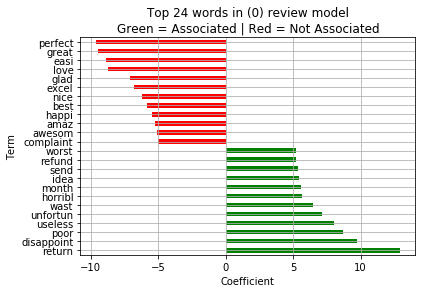

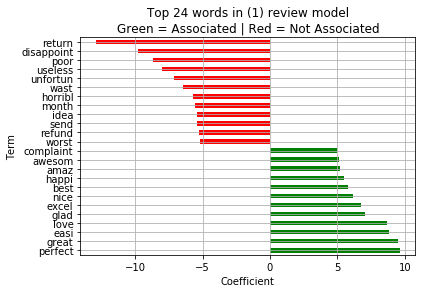

In [44]:
%matplotlib inline

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=cat[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)

### Test output

To put it altogether, below is a test function which allows you to supply your own review to see how well the model will predict it's rating. For simplicity, I stuck with the logistic regression model and only allow for one review at a time.

The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of our logistic regression models. Each model has an independent assessment of how likely it is that our review is a positive hit. You could set some sort of threshold or take the model with the higest likelihood to make your determination.

In [49]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,2):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=lr_m[m].predict_proba(test_new)[0][1]))

In [50]:
test_review('I bought these knives last week. I immediately returned these when they arrived damaged.')

Review text: "I bought these knives last week. I immediately returned these when they arrived damaged."

Model Predction
Model (0): 99.5%
Model (1): 0.5%


In [73]:
test_review('This idea is nice.')

Review text: "This idea is nice."

Model Predction
Model (0): 78.4%
Model (1): 21.6%


In [51]:
test_review('This is the best toaster oven I have ever owned! I am glad I bought it.')

Review text: "This is the best toaster oven I have ever owned! I am glad I bought it."

Model Predction
Model (0): 0.3%
Model (1): 99.7%


In [52]:
test_review('My name is Yimin.')

Review text: "My name is Yimin."

Model Predction
Model (0): 57.2%
Model (1): 42.8%


In [53]:
test_review('My weight is a secret.')

Review text: "My weight is a secret."

Model Predction
Model (0): 41.7%
Model (1): 58.3%


In [54]:
test_review('This is not a comment.')

Review text: "This is not a comment."

Model Predction
Model (0): 20.0%
Model (1): 80.0%


In [55]:
test_review('I am a superman.')

Review text: "I am a superman."

Model Predction
Model (0): 57.2%
Model (1): 42.8%


In [56]:
test_review('I like computer science')

Review text: "I like computer science"

Model Predction
Model (0): 36.5%
Model (1): 63.5%


In [57]:
test_review('I am very glad that I did not buy this product.')

Review text: "I am very glad that I did not buy this product."

Model Predction
Model (0): 9.0%
Model (1): 91.0%


In [59]:
test_review('I hate that I did not buy this product.')

Review text: "I hate that I did not buy this product."

Model Predction
Model (0): 98.5%
Model (1): 1.5%


In [60]:
test_review('This is the best oven my husband has ever owned! I am glad I bought it.')

Review text: "This is the best oven my husband has ever owned! I am glad I bought it."

Model Predction
Model (0): 0.2%
Model (1): 99.8%


In [71]:
test_review('This is the worst oven my husband has ever owned! I am glad I bought it.')

Review text: "This is the worst oven my husband has ever owned! I am glad I bought it."

Model Predction
Model (0): 31.9%
Model (1): 68.1%
